# Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Rescaling
from keras import Model
import tensorflow_hub as hub

tf.__version__

'2.12.0'

In [2]:
SLICE_DURATION = 0.5
SAMPLING_RATE = 22500
N_FFT = 2048
HOP_LENGTH = N_FFT // 8
N_MELS=512
MEL_MIN_HZ = 0
MEL_MAX_HZ = SAMPLING_RATE / 2

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
N_KERNELS = 10
N_FILTERS = 1

N_EPOCHS = 10

In [3]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

In [4]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

In [5]:
random_slice = slices[np.random.randint(len(slices))]

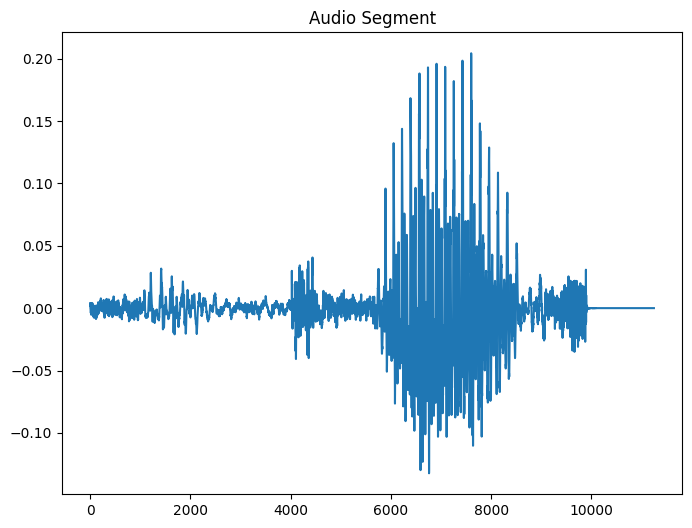

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [7]:
def get_stft(audio_slice):
    window = np.hanning(N_FFT)
    spectrogram = librosa.stft(audio_slice, n_fft=N_FFT, hop_length=HOP_LENGTH, window=window)
    return np.abs(spectrogram)

In [8]:
def plot_stft(ft, sampling_rate):
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

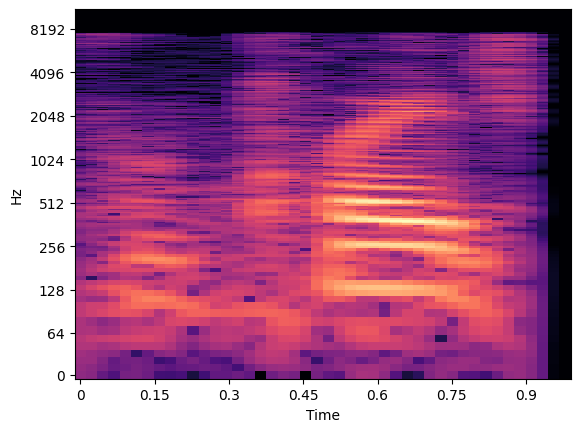

In [9]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [10]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

In [11]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((11, 1025, 44),
 array([[5.02947867e-01, 4.10338908e-01, 2.19858512e-01, ...,
         1.77299783e-01, 2.32145220e-01, 2.24364296e-01],
        [5.34973085e-01, 4.58131641e-01, 2.71615654e-01, ...,
         1.47755355e-01, 1.01530790e-01, 1.29609093e-01],
        [5.24474740e-01, 4.74888742e-01, 3.18895251e-01, ...,
         1.41565099e-01, 1.01138003e-01, 1.13104239e-01],
        ...,
        [7.63271237e-04, 6.51112699e-04, 3.80949525e-04, ...,
         1.13389076e-04, 3.65803397e-04, 6.09521579e-04],
        [7.63264892e-04, 6.51106297e-04, 3.80946818e-04, ...,
         1.13425856e-04, 3.65813845e-04, 6.09526876e-04],
        [7.63264252e-04, 6.51109498e-04, 3.80952901e-04, ...,
         1.13401264e-04, 3.65794229e-04, 6.09519135e-04]], dtype=float32))

In [12]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(1025, 44)

# Create Train and Test Splits

In [13]:
male_voice_dir = "males"
female_voice_dir = "females"

In [14]:
def get_file_paths_from_dir(path):
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

In [15]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

In [16]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Models

## STFT Based Model

In [17]:
def audio_preprocess_stft(file_path, label):
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    expanded_stfts = np.array([tf.expand_dims(slice_stft, -1) for slice_stft in slice_stfts])
    return expanded_stfts, labels

In [18]:
def set_tensor_shapes_stft(slice_data, label):
    slice_data.set_shape(STFT_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [19]:
train_dataset_stft = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_stft = train_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_stft = train_dataset_stft.map(set_tensor_shapes_stft)

train_dataset_stft = train_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [20]:
val_dataset_stft = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_stft = val_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_stft = val_dataset_stft.map(set_tensor_shapes_stft)

val_dataset_stft = val_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [21]:
tf.random.set_seed(42)

inputs = Input(shape=STFT_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="cnn_model")(x)
model_cnn_stft = Model(inputs, outputs)

In [22]:
model_cnn_stft.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [23]:
history_cnn_stft = model_cnn_stft.fit(train_dataset_stft,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_stft)

Epoch 1/10


2023-06-16 23:42:58.994024: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 150s 79ms/step - loss: 0.4871 - accuracy: 0.7982 - val_loss: 0.4942 - val_accuracy: 0.7904
Epoch 2/10
568/568 [==============================] - 33s 58ms/step - loss: 0.4258 - accuracy: 0.8354 - val_loss: 0.4473 - val_accuracy: 0.8130
Epoch 3/10
568/568 [==============================] - 33s 58ms/step - loss: 0.3895 - accuracy: 0.8451 - val_loss: 0.4127 - val_accuracy: 0.8202
Epoch 4/10
568/568 [==============================] - 33s 58ms/step - loss: 0.3733 - accuracy: 0.8487 - val_loss: 0.3948 - val_accuracy: 0.8262
Epoch 5/10
568/568 [==============================] - 33s 58ms/step - loss: 0.3645 - accuracy: 0.8514 - val_loss: 0.3847 - val_accuracy: 0.8294
Epoch 6/10
568/568 [==============================] - 33s 58ms/step - loss: 0.3578 - accuracy: 0.8535 - val_loss: 0.3781 - val_accuracy: 0.8339
Epoch 7/10
568/568 [==============================] - 33s 58ms/step - loss: 0.3533 - accuracy: 0.8552 - val_loss: 0.3696 - val_accuracy: 0.8405
Ep

In [24]:
model_cnn_stft.evaluate(val_dataset_stft)

65/65 [==============================] - 1s 16ms/step - loss: 0.3685 - accuracy: 0.8376


[0.3684510886669159, 0.8375777006149292]

## Mel Spectogram Based Model

In [19]:
def get_mel_spec(audio_slice):
    window = np.hanning(N_FFT)
    return librosa.feature.melspectrogram(
        y=audio_slice,
        sr=SAMPLING_RATE,
        n_fft=N_FFT,
        window=window,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=MEL_MIN_HZ,
        fmax=MEL_MAX_HZ
    )


In [20]:
def plot_mel_spec(mel_spec, sampling_rate=SAMPLING_RATE, f_max=MEL_MAX_HZ):
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(
        spec_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate,
        fmax=f_max,
        ax=ax
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

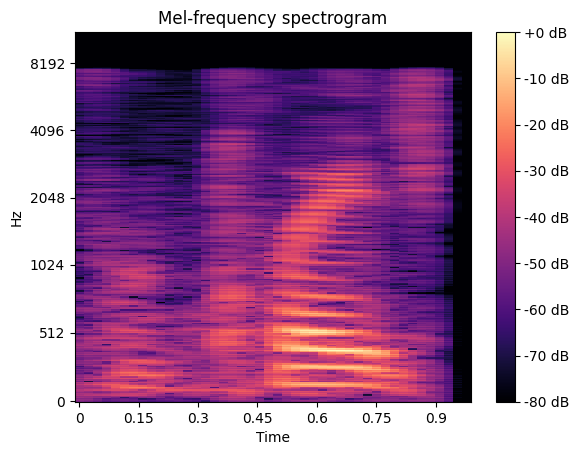

In [21]:
mel_spec_slice = get_mel_spec(random_slice)
plot_mel_spec(mel_spec_slice)

In [22]:
def get_audio_slices_mel_spec(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_mel_spec(audio_slice) for audio_slice in audio_slices])

In [23]:
mel_spec = get_audio_slices_mel_spec("males/0.wav")
mel_spec.shape, mel_spec[0]

((11, 512, 44),
 array([[1.3865652e-02, 1.0168502e-02, 3.5742589e-03, ..., 1.0577010e-03,
         4.9942691e-04, 8.1385561e-04],
        [3.0000579e-02, 2.2001198e-02, 7.7334866e-03, ..., 2.2885068e-03,
         1.0805909e-03, 1.7609081e-03],
        [2.6653582e-02, 2.1851948e-02, 9.8537719e-03, ..., 1.9418640e-03,
         9.9114038e-04, 1.2395503e-03],
        ...,
        [5.3025701e-08, 3.8586936e-08, 1.3208908e-08, ..., 1.1694198e-09,
         1.2168350e-08, 3.3783845e-08],
        [5.3023363e-08, 3.8585434e-08, 1.3208493e-08, ..., 1.1699423e-09,
         1.2173836e-08, 3.3799115e-08],
        [5.3027730e-08, 3.8588599e-08, 1.3209573e-08, ..., 1.1704059e-09,
         1.2178660e-08, 3.3812540e-08]], dtype=float32))

In [24]:
MEL_SPEC_SHAPE = mel_spec.shape[-2:]
MEL_SPEC_SHAPE

(512, 44)

In [25]:
def audio_preprocess_mel_spec(file_path, label):
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([tf.expand_dims(slice_mel_spec, -1) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [26]:
def set_tensor_shapes_mel_spec(slice_data, label):
    slice_data.set_shape(MEL_SPEC_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [27]:
train_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_mel_spec = train_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_mel_spec = train_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

train_dataset_mel_spec = train_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [28]:
val_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_mel_spec = val_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_mel_spec = val_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

val_dataset_mel_spec = val_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [32]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_mel_spec = Model(inputs, outputs)

In [33]:
model_cnn_mel_spec.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
history_cnn_mel_spec = model_cnn_mel_spec.fit(train_dataset_mel_spec,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_mel_spec)

Epoch 1/10


2023-06-17 00:02:02.600767: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 794s 206ms/step - loss: 0.6503 - accuracy: 0.7052 - val_loss: 0.5467 - val_accuracy: 0.7799
Epoch 2/10
568/568 [==============================] - 19s 34ms/step - loss: 0.4806 - accuracy: 0.7894 - val_loss: 0.4367 - val_accuracy: 0.7992
Epoch 3/10
568/568 [==============================] - 19s 34ms/step - loss: 0.4142 - accuracy: 0.8229 - val_loss: 0.4117 - val_accuracy: 0.8203
Epoch 4/10
568/568 [==============================] - 20s 34ms/step - loss: 0.3942 - accuracy: 0.8333 - val_loss: 0.4029 - val_accuracy: 0.8241
Epoch 5/10
568/568 [==============================] - 20s 34ms/step - loss: 0.3812 - accuracy: 0.8409 - val_loss: 0.4011 - val_accuracy: 0.8269
Epoch 6/10
568/568 [==============================] - 19s 34ms/step - loss: 0.3704 - accuracy: 0.8448 - val_loss: 0.4001 - val_accuracy: 0.8315
Epoch 7/10
568/568 [==============================] - 20s 35ms/step - loss: 0.3680 - accuracy: 0.8462 - val_loss: 0.3953 - val_accuracy: 0.8336
E

In [31]:
model_cnn_mel_spec.evaluate(val_dataset_mel_spec)

65/65 [==============================] - 1s 10ms/step - loss: 0.3904 - accuracy: 0.8401


[0.3903779089450836, 0.8401364684104919]

## Convert spectrogram to image

In [38]:
def scale_minmax(spec, min=0.0, max=1.0):
    spec_std = (spec - spec.min()) / (spec.max() - spec.min())
    spec_scaled = spec_std * (max - min) + min
    return spec_scaled

In [39]:
def convert_to_img(spec):
    spec_log = np.log(spec + 1e-9)
    img = scale_minmax(spec_log, 0.0, 1.0).astype(np.float64)
    img = np.flip(img, axis=0)
    rgb_img = np.array([[[s, s, s] for s in r] for r in img], dtype="f")
    return rgb_img

In [40]:
mel_img = convert_to_img(mel_spec_slice)
MEL_IMG_SHAPE = mel_img.shape
MEL_IMG_SHAPE

(512, 44, 3)

In [41]:
def audio_preprocess_mel_img(file_path, label):
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([convert_to_img(slice_mel_spec) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [42]:
def set_tensor_shapes_mel_img(slice_data, label):
    slice_data.set_shape(MEL_IMG_SHAPE)
    label.set_shape(())
    return slice_data, label

In [43]:
train_mel_img_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_mel_img_dataset = train_mel_img_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_img,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_mel_img_dataset = train_mel_img_dataset.map(set_tensor_shapes_mel_img)

train_mel_img_dataset = train_mel_img_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [44]:
val_mel_img_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_mel_img_dataset = val_mel_img_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_img,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_mel_img_dataset = val_mel_img_dataset.map(set_tensor_shapes_mel_img)

val_mel_img_dataset = val_mel_img_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

## RGB Image CNN

In [36]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (3,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_rgb = Model(inputs, outputs)

In [37]:
model_cnn_rgb.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
history_cnn_rgb = model_cnn_rgb.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset)

Epoch 1/10
568/568 [==============================] - 2506s 478ms/step - loss: 0.6193 - accuracy: 0.6554 - val_loss: 0.4717 - val_accuracy: 0.7685
Epoch 2/10
568/568 [==============================] - 25s 44ms/step - loss: 0.3915 - accuracy: 0.8304 - val_loss: 0.3644 - val_accuracy: 0.8414
Epoch 3/10
568/568 [==============================] - 22s 38ms/step - loss: 0.3513 - accuracy: 0.8512 - val_loss: 0.3544 - val_accuracy: 0.8476
Epoch 4/10
568/568 [==============================] - 22s 38ms/step - loss: 0.3424 - accuracy: 0.8553 - val_loss: 0.3542 - val_accuracy: 0.8495
Epoch 5/10
568/568 [==============================] - 22s 38ms/step - loss: 0.3376 - accuracy: 0.8567 - val_loss: 0.3559 - val_accuracy: 0.8504
Epoch 6/10
568/568 [==============================] - 22s 38ms/step - loss: 0.3352 - accuracy: 0.8582 - val_loss: 0.3575 - val_accuracy: 0.8492
Epoch 7/10
568/568 [==============================] - 22s 38ms/step - loss: 0.3333 - accuracy: 0.8590 - val_loss: 0.3585 - val_accura

In [51]:
model_cnn_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 1s 11ms/step - loss: 0.3566 - accuracy: 0.8518


[0.35656237602233887, 0.8518338203430176]

# Transfer Learning Models

## EfficientNet B0

In [60]:
feature_extractor_layer_eff_b0 = tf.keras.applications.EfficientNetB0(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_eff_b0 = tf.keras.Sequential([
    feature_extractor_layer_eff_b0,
    Dense(1, activation='sigmoid', name='output_layer')
])

In [61]:
model_mel_img_eff_b0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
history_mel_img_eff_b0 = model_mel_img_eff_b0.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset)

Epoch 1/10
568/568 [==============================] - 239s 398ms/step - loss: 0.6045 - accuracy: 0.7269 - val_loss: 0.7368 - val_accuracy: 0.3916
Epoch 2/10
568/568 [==============================] - 220s 385ms/step - loss: 0.3974 - accuracy: 0.8296 - val_loss: 0.3286 - val_accuracy: 0.8599
Epoch 3/10
568/568 [==============================] - 223s 390ms/step - loss: 0.3134 - accuracy: 0.8759 - val_loss: 0.3149 - val_accuracy: 0.8633
Epoch 4/10
568/568 [==============================] - 367s 645ms/step - loss: 0.2798 - accuracy: 0.8917 - val_loss: 0.3142 - val_accuracy: 0.8751
Epoch 5/10
568/568 [==============================] - 227s 399ms/step - loss: 0.2728 - accuracy: 0.8954 - val_loss: 0.4164 - val_accuracy: 0.8676
Epoch 6/10
568/568 [==============================] - 217s 380ms/step - loss: 0.2491 - accuracy: 0.9067 - val_loss: 0.3150 - val_accuracy: 0.8741
Epoch 7/10
568/568 [==============================] - 322s 566ms/step - loss: 0.2474 - accuracy: 0.9088 - val_loss: 0.2741 -

In [58]:
model_mel_img_eff_b0.evaluate(val_mel_img_dataset)

65/65 [==============================] - 5s 83ms/step - loss: 0.2950 - accuracy: 0.8869


[0.2950475811958313, 0.8869258165359497]

## EfficientNet B3

In [45]:
feature_extractor_layer_eff_b3 = tf.keras.applications.EfficientNetB3(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_eff_b3 = tf.keras.Sequential([
    feature_extractor_layer_eff_b3,
    Dense(1, activation='sigmoid', name='output_layer')
])

In [46]:
model_mel_img_eff_b3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
history_mel_img_eff_b3 = model_mel_img_eff_b3.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset)

Epoch 1/10


2023-06-17 16:14:14.774258: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 4683s 4s/step - loss: 0.5940 - accuracy: 0.7156 - val_loss: 0.6705 - val_accuracy: 0.6084
Epoch 2/10
568/568 [==============================] - 453s 793ms/step - loss: 0.4468 - accuracy: 0.8055 - val_loss: 0.3747 - val_accuracy: 0.8366
Epoch 3/10
568/568 [==============================] - 437s 768ms/step - loss: 0.4298 - accuracy: 0.8212 - val_loss: 0.3883 - val_accuracy: 0.8350
Epoch 4/10
568/568 [==============================] - 437s 766ms/step - loss: 0.3612 - accuracy: 0.8594 - val_loss: 0.3058 - val_accuracy: 0.8729
Epoch 5/10
568/568 [==============================] - 438s 768ms/step - loss: 0.3106 - accuracy: 0.8829 - val_loss: 0.2891 - val_accuracy: 0.8807
Epoch 6/10
568/568 [==============================] - 436s 765ms/step - loss: 0.2708 - accuracy: 0.8972 - val_loss: 0.2891 - val_accuracy: 0.8780
Epoch 7/10
568/568 [==============================] - 436s 765ms/step - loss: 0.2384 - accuracy: 0.9105 - val_loss: 0.2851 - val_accuracy

In [48]:
model_mel_img_eff_b3.evaluate(val_mel_img_dataset)

65/65 [==============================] - 12s 180ms/step - loss: 0.2940 - accuracy: 0.8851


[0.29398736357688904, 0.8850980997085571]

## VGG 19

In [58]:
feature_extractor_layer_vgg_19 = tf.keras.applications.VGG19(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_vgg_19 = tf.keras.Sequential([
    feature_extractor_layer_vgg_19,
    Dense(1, activation='sigmoid', name='output_layer')
])

In [59]:
model_mel_img_vgg_19.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
history_mel_img_vgg_19 = model_mel_img_vgg_19.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset)

Epoch 1/10
568/568 [==============================] - 565s 991ms/step - loss: 1.2411 - accuracy: 0.6042 - val_loss: 0.6712 - val_accuracy: 0.6084
Epoch 2/10
568/568 [==============================] - 713s 1s/step - loss: 0.6717 - accuracy: 0.6049 - val_loss: 0.6704 - val_accuracy: 0.6084
Epoch 3/10
568/568 [==============================] - 555s 976ms/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6704 - val_accuracy: 0.6084
Epoch 4/10
568/568 [==============================] - 892s 2s/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6704 - val_accuracy: 0.6084
Epoch 5/10
568/568 [==============================] - 562s 989ms/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6703 - val_accuracy: 0.6084
Epoch 6/10
568/568 [==============================] - 552s 972ms/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6703 - val_accuracy: 0.6084
Epoch 7/10
568/568 [==============================] - 551s 970ms/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6703 - val_a

In [61]:
model_mel_img_vgg_19.evaluate(val_mel_img_dataset)

65/65 [==============================] - 17s 258ms/step - loss: 0.6703 - accuracy: 0.6084


[0.6703282594680786, 0.608383059501648]

## Resnet 50 V2

In [53]:
feature_extractor_layer_resnet_50v2 = tf.keras.applications.ResNet50V2(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_resnet_50v2 = tf.keras.Sequential([
    feature_extractor_layer_resnet_50v2,
    Dense(1, activation='sigmoid', name='output_layer')
])

In [54]:
model_mel_img_resnet_50v2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
history_mel_img_resnet_50v2 = model_mel_img_resnet_50v2.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset)

Epoch 1/10
568/568 [==============================] - 600s 1s/step - loss: 0.5254 - accuracy: 0.7838 - val_loss: 2.7479 - val_accuracy: 0.6084
Epoch 2/10
568/568 [==============================] - 275s 485ms/step - loss: 0.3891 - accuracy: 0.8347 - val_loss: 2.5629 - val_accuracy: 0.6129
Epoch 3/10
568/568 [==============================] - 274s 482ms/step - loss: 0.3470 - accuracy: 0.8558 - val_loss: 0.8631 - val_accuracy: 0.6867
Epoch 4/10
568/568 [==============================] - 272s 479ms/step - loss: 0.3056 - accuracy: 0.8765 - val_loss: 1.0634 - val_accuracy: 0.6558
Epoch 5/10
568/568 [==============================] - 333s 586ms/step - loss: 0.2885 - accuracy: 0.8873 - val_loss: 1.6338 - val_accuracy: 0.6157
Epoch 6/10
568/568 [==============================] - 271s 478ms/step - loss: 0.2795 - accuracy: 0.8904 - val_loss: 0.9689 - val_accuracy: 0.6519
Epoch 7/10
568/568 [==============================] - 264s 465ms/step - loss: 0.2680 - accuracy: 0.8956 - val_loss: 0.7214 - va

In [57]:
model_mel_img_resnet_50v2.evaluate(val_mel_img_dataset)

65/65 [==============================] - 7s 101ms/step - loss: 0.9321 - accuracy: 0.6876


[0.9320501089096069, 0.6875837445259094]